In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import importance_sampler_poise
import kl_divergence_calculator
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
import random
random.seed(30)

importing Jupyter notebook from importance_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb


In [2]:
def sample(mu, var, nb_samples):
    """
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [torch.normal(mu, var.sqrt())]
    return torch.stack(out, dim=0)
## Creating synthetic datasets
nb_samples=5000
mu1  =torch.tensor(0.)   # . converts long to float
var1 =torch.tensor(1.0)
mu2  =torch.tensor(0.)   # . converts long to float
var2 =torch.tensor(1.0)

inp_data1=sample(mu1,var1,nb_samples)  
inp_data1=inp_data1.unsqueeze(0)+torch.randn_like(inp_data1)##Adding gaussian noise to data
inp_data1=torch.transpose(inp_data1,0,1)

inp_data2=sample(mu2,var2,nb_samples)
inp_data2=inp_data2.unsqueeze(0)+torch.randn_like(inp_data2)  ##Adding gaussian noise to data
inp_data2=torch.transpose(inp_data2,0,1)

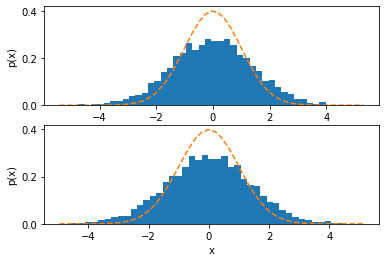

mu1 tensor(0.)
var1 tensor(1.)
mu2 tensor(0.)
var2 tensor(1.)


In [3]:
## for data visualization
data_vis1=inp_data1.numpy()
data_vis2=inp_data2.numpy()
fig, ax = plt.subplots(2,1)
#flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
#Panel a
n1,bins1,patches1=ax[0].hist(data_vis1,'auto',density=1)
y1=1/(np.sqrt(2*np.pi*var1))*np.exp(-0.5*(bins1-mu1.numpy())**2/var1)
ax[0].plot(bins1,y1,'--')
ax[0].set(xlabel='x',ylabel='p(x)')
#Panel b
n2,bins2,patches2=ax[1].hist(data_vis2,'auto',density=1)
y2=1/(np.sqrt(2*np.pi*var2))*np.exp(-0.5*(bins2-mu2.numpy())**2/var2)
ax[1].plot(bins2,y2,'--')
ax[1].set(xlabel='x',ylabel='p(x)')
plt.show()
print("mu1",mu1)
print("var1",var1)
print("mu2",mu2)
print("var2",var2)

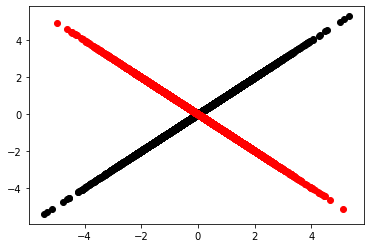

In [4]:
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
dim_exp = 2 
#fun_A1   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
#fun_A2   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
fun_A1 = torch.tensor([1,1])
fun_A2 = torch.tensor([1,-1])

data1    = inp_data1*fun_A1
data2    = inp_data2*fun_A2
x1_cord = data1[:,0]
y1_cord = data1[:,1]
x2_cord = data2[:,0]
y2_cord = data2[:,1]
plt.plot(x1_cord,y1_cord, 'o', color='black')
plt.plot(x2_cord,y2_cord, 'o', color='red')
plt.show()

In [5]:
## Hyperparameters
batch_size = 128
latent_dim1 = 1
latent_dim2 = 1
lr         = 5e-4
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
## Creating synthetic dataloader

train_loader_set1 = DataLoader(
    data1[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set1 = DataLoader(
    data1[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
train_loader_set2 = DataLoader(
    data2[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set2 = DataLoader(
    data2[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [7]:
## Neural net is like: [mu,logvar]=(relu(xA))B,x=sig((relu(zC))D)


        
class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.kl_div                  = kl_divergence_calculator.kl_divergence(self.latent_dim1, self.latent_dim2, self.batch_size)
        self.IS_sampler              = importance_sampler_poise.importance_sampler(self.latent_dim1, self.latent_dim2, self.batch_size)
        self.n_IW_samples = 20
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        ## Encoder set1
        self.set1_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim1)
        self.set1_enc2 = nn.Linear(in_features = 2*latent_dim1,out_features = 2*latent_dim1)
        ## Encoder set2
        self.set2_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim2)
        self.set2_enc2 = nn.Linear(in_features = 2*latent_dim2,out_features = 2*latent_dim2)
        ## Decoder set1
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = dim_exp,bias=False)
        ## Decoder set2
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = dim_exp,bias=False)
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim1)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)
    def weighted_mse_loss(self,weights,reconstruction,data):
#         print('weights',weights.size())
#         print('reconstruction',reconstruction.size())
#         print('data',data.size())
        loss = torch.sum(weights * ((data - reconstruction) ** 2).T)
        return loss
    def forward(self,x1,x2):
        data1    = x1
        data2    = x2
        ## encoding
# Modality 1
        x1       = self.set1_enc1(x1)
        x1       = self.set1_enc2(x1)
        mu1      = x1[:,0]
        mu1      = mu1.unsqueeze(0)
        mu1      = torch.transpose(mu1,0,1)    
        log_var1 = x1[:,1]
        log_var1 = log_var1.unsqueeze(0)
        log_var1 = torch.transpose(log_var1,0,1)    
        var1     = -torch.exp(log_var1)         # lambda_2<0
# Modality 2        
        x2       = self.set2_enc1(x2)
        x2       = self.set2_enc2(x2)        
        mu2      = x2[:,0]
        mu2      = mu2.unsqueeze(0)
        mu2      = torch.transpose(mu2,0,1)    
        log_var2 = x2[:,1]
        log_var2 = log_var2.unsqueeze(0)
        log_var2 = torch.transpose(log_var2,0,1) 
        var2     = -torch.exp(log_var2)           #lambdap_2<0
        g22      = -torch.exp(self.g22)     
        g11_copy = self.g11.detach()
        g22_copy = g22.detach()
        mu1_copy = mu1.detach()
        mu2_copy = mu2.detach()
        var1_copy=var1.detach()
        var2_copy=var2.detach()      
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)
        z1_prior,z2_prior,z1_posterior,z2_posterior,IS_weights_prior,IS_weights_post = self.IS_sampler.calc(G,mu1,var1,mu2,var2,self.n_IW_samples)
        ## decoding
        loss = 0
        for i in range(self.n_IW_samples):
            self.z1_IS_prior     = z1_prior[i]
            self.z2_IS_prior     = z2_prior[i]
            self.z1_IS_posterior = z1_posterior[i]
            self.z2_IS_posterior = z2_posterior[i]
#             part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_IS_posterior,self.z2_IS_posterior,self.z1_IS_prior,self.z2_IS_prior,mu1,var1,mu2,var2)
            reconstruction1      = (self.set1_dec1(self.z1_IS_posterior.unsqueeze(0))).squeeze()
            reconstruction2      = (self.set2_dec1(self.z2_IS_posterior.unsqueeze(0))).squeeze()
            ## loss
            MSE1 = self.weighted_mse_loss(IS_weights_post[i,:],reconstruction1, data1)
            MSE2 = self.weighted_mse_loss(IS_weights_post[i,:],reconstruction2, data2)
#             KLD  = torch.sum(IS_weights_post[i,:]*torch.sum(part_fun0+part_fun1,dim=1)+part_fun2 )
            loss = loss+MSE1+MSE2
        return reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss

In [8]:
model = VAE(latent_dim1, latent_dim2, batch_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set1_dec1.weight
set2_dec1.weight


In [9]:
def train(model,dataloader1,dataloader2):
    model.train()
    running_loss = 0
    for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
        data1                        = data1.to(device)
        data2                        = data2.to(device)   
        optimizer.zero_grad()
        reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss       = model(data1,data2)     
        running_loss                += loss.item()
        loss.backward() 
        optimizer.step()
#         for p in model.parameters():
#             print(p.grad.norm())
    train_loss = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    return train_loss
def test(model,dataloader1,dataloader2):
    mean1_pred = []
    var1_pred  = []
    mean2_pred = []
    var2_pred  = []
    data1_val  = [] 
    data2_val  = [] 
    reconstruction1_pred=[]
    reconstruction2_pred=[]
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
            data1                        = data1.to(device)
            data2                        = data2.to(device)        
            reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss = model(data1,data2)  
            running_loss              += loss.item()
            mean1_pred                += [torch.mean(mu1)]
            var1_pred                 += [torch.mean(var1)]
            mean2_pred                += [torch.mean(mu2)]
            var2_pred                 += [torch.mean(var2)]
            reconstruction1_pred.append(reconstruction1)
            reconstruction2_pred.append(reconstruction2)
            data1_val.append(data1)
            data2_val.append(data2)

    test_loss   = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    reconstruction1_pred = torch.vstack(reconstruction1_pred)
    reconstruction2_pred = torch.vstack(reconstruction2_pred)
    data1_val   = torch.vstack(data1_val)
    data2_val   = torch.vstack(data2_val)

    mean1_pred  = torch.stack(mean1_pred,dim=0)
    var1_pred   = torch.stack(var1_pred,dim=0)
    mean1_pred  = torch.mean(mean1_pred)
    var1_pred   = torch.mean(var1_pred)
    mean2_pred  = torch.stack(mean2_pred,dim=0)
    var2_pred   = torch.stack(var2_pred,dim=0)
    mean2_pred  = torch.mean(mean2_pred)
    var2_pred   = torch.mean(var2_pred)
    return data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_loss,mean1_pred,var1_pred,mean2_pred,var2_pred

In [10]:
epochs     = 500
train_loss = []
test_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader_set1,train_loader_set2)
    data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_epoch_loss,mean1_pred,var1_pred,mean2_pred,var2_pred = test(model,test_loader_set1,test_loader_set2)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    
#     for name, para in model.named_parameters():
#         print(para)
    #print(f"Train Loss    : {train_epoch_loss:.4f}")
print(f"Test Loss     :  {test_epoch_loss:.4f}")
print(f"Mean Pred set1:  {mean1_pred:.4f}")
print(f"Var  Pred set1:  {var1_pred:.4f}")
print(f"Mean Pred set2:  {mean2_pred:.4f}")
print(f"Var  Pred set2:  {var2_pred:.4f}")

Epoch 1 of 500
Epoch 2 of 500
Epoch 3 of 500
Epoch 4 of 500
Epoch 5 of 500
Epoch 6 of 500
Epoch 7 of 500
Epoch 8 of 500
Epoch 9 of 500
Epoch 10 of 500
Epoch 11 of 500
Epoch 12 of 500
Epoch 13 of 500
Epoch 14 of 500
Epoch 15 of 500
Epoch 16 of 500
Epoch 17 of 500
Epoch 18 of 500
Epoch 19 of 500
Epoch 20 of 500
Epoch 21 of 500
Epoch 22 of 500
Epoch 23 of 500
Epoch 24 of 500
Epoch 25 of 500
Epoch 26 of 500
Epoch 27 of 500
Epoch 28 of 500
Epoch 29 of 500
Epoch 30 of 500
Epoch 31 of 500
Epoch 32 of 500
Epoch 33 of 500
Epoch 34 of 500
Epoch 35 of 500
Epoch 36 of 500
Epoch 37 of 500
Epoch 38 of 500
Epoch 39 of 500
Epoch 40 of 500
Epoch 41 of 500
Epoch 42 of 500
Epoch 43 of 500
Epoch 44 of 500
Epoch 45 of 500
Epoch 46 of 500
Epoch 47 of 500
Epoch 48 of 500
Epoch 49 of 500
Epoch 50 of 500
Epoch 51 of 500
Epoch 52 of 500
Epoch 53 of 500
Epoch 54 of 500
Epoch 55 of 500
Epoch 56 of 500
Epoch 57 of 500
Epoch 58 of 500
Epoch 59 of 500
Epoch 60 of 500
Epoch 61 of 500
Epoch 62 of 500
Epoch 63 of 500
E

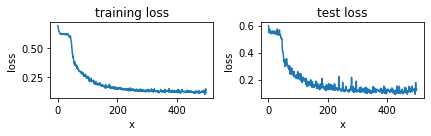

In [11]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

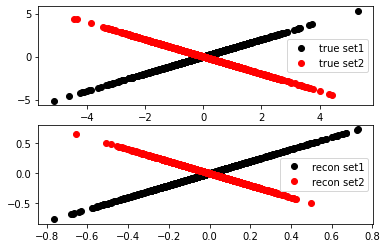

In [12]:
reconstruction1_pred =np.reshape(reconstruction1_pred.cpu().detach().numpy(),(896,2))
reconstruction2_pred =np.reshape(reconstruction2_pred.cpu().detach().numpy(),(896,2))
reconstruction1_x_cord = reconstruction1_pred[:,0]
reconstruction1_y_cord = reconstruction1_pred[:,1]
reconstruction2_x_cord = reconstruction2_pred[:,0]
reconstruction2_y_cord = reconstruction2_pred[:,1]
data1_x_cord = data1_val[:,0].cpu().detach().numpy()
data1_y_cord = data1_val[:,1].cpu().detach().numpy()
data2_x_cord = data2_val[:,0].cpu().detach().numpy()
data2_y_cord = data2_val[:,1].cpu().detach().numpy()

fig, ax = plt.subplots(2)

ax[0].plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
ax[0].plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
ax[0].legend()
ax[1].plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='black',label='recon set1')
ax[1].plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='red',label='recon set2')
ax[1].legend()
plt.show()

In [13]:
np.shape(data1_x_cord)

(896,)

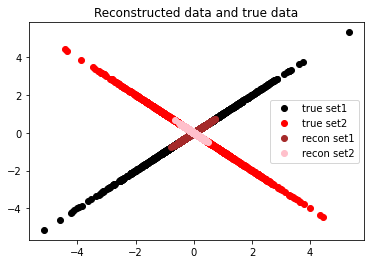

In [14]:
plt.plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
plt.plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
plt.plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='brown',label='recon set1')
plt.plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='pink',label='recon set2')
plt.title('Reconstructed data and true data')
plt.legend()
plt.show()

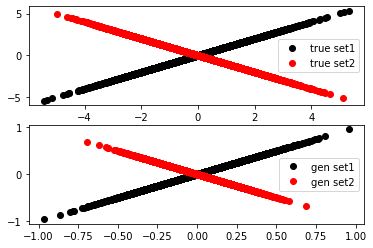

In [15]:
## Transforming data to a higher dimension
mean_pred  = torch.tensor(0.).cpu()   # . converts long to float
var_pred   = torch.tensor(1.0).cpu()
gen_data   = sample(mean_pred,var_pred,nb_samples)
gen_data   = gen_data.unsqueeze(1)

"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
#fun_A   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
param_dict={}
for name, para in model.named_parameters():
    param_dict[name]=para

A1=param_dict["set1_dec1.weight"]
A2=param_dict["set2_dec1.weight"]
set1_dec1_wgt=A1
set2_dec1_wgt=A2
set1_dec1_wgt  = (torch.transpose(set1_dec1_wgt,0,1)).cpu()
set2_dec1_wgt  = (torch.transpose(set2_dec1_wgt,0,1)).cpu()

data1_sim= gen_data*set1_dec1_wgt
data2_sim= gen_data*set2_dec1_wgt

dat1_x_cord = data1_sim[:,0].cpu().detach().numpy()
dat1_y_cord = data1_sim[:,1].cpu().detach().numpy()
dat2_x_cord = data2_sim[:,0].cpu().detach().numpy()
dat2_y_cord = data2_sim[:,1].cpu().detach().numpy()

fig, ax = plt.subplots(2)

ax[0].plot(x1_cord,y1_cord, 'o', color='black',label='true set1')
ax[0].plot(x2_cord,y2_cord, 'o', color='red',label='true set2')
ax[0].legend()
ax[1].plot(dat1_x_cord,dat1_y_cord, 'o', color='black',label='gen set1')
ax[1].plot(dat2_x_cord,dat2_y_cord, 'o', color='red',label='gen set2')
ax[1].legend()
plt.show()

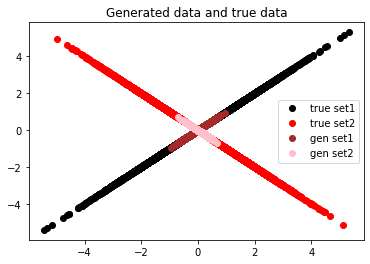

In [16]:
plt.plot(x1_cord,y1_cord, 'o', color='black',label='true set1')
plt.plot(x2_cord,y2_cord, 'o', color='red',label='true set2')
plt.plot(dat1_x_cord,dat1_y_cord, 'o', color='brown',label='gen set1')
plt.plot(dat2_x_cord,dat2_y_cord, 'o', color='pink',label='gen set2')
plt.title('Generated data and true data')
plt.legend()
plt.show()